In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

**Перед тем как начать выполнять задание, определитесь где вы будете обучать модель: на GPU или CPU.**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Проблема затухания градиента

Рассмотрим проблему затухания градиента во время обучений неройнных сетей

**Залача 1:** Определите модель со следующей структурой:
1. Вход и выход заданы - линейными слоями (nn.Linear)
2. Скрытые слои - в виде линейных слоев в nn.ModuleList

In [3]:
# Класс модели:
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden):
        super(DeepMLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = F.sigmoid(hidden_layer(x))
        x = self.output_layer(x)
        return x


**Вопрос:** Сколько параметров (весов) будет иметь эта модель, если инициализировать ее следующие аргументами:

input_size=3, 
hidden_size=6,
output_size=7,
n_hidden=1

**Пример ответа:** `123`

In [4]:
model = DeepMLP(input_size=3, hidden_size=6,output_size=7,n_hidden=1)
answer = sum(w.numel() for w in model.parameters())
answer # 115

115

**Задача 2:** Вычислите среднее по градиенту в первом скрытом (!!!) слое.

**Вопрос:** Каково это значение?

**Пример ответа:** `1.2`

In [9]:
torch.manual_seed(42)

model = DeepMLP(28 * 28, 6, 7, 1)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer.zero_grad()
out = model(torch.rand((1, 28 * 28)))
loss = criterion(out, torch.rand((1, )).long())

loss.backward()

In [72]:
answer = model.hidden_layers[0].weight.grad.mean().item()
answer # -0.00047465492389164865


-5.3674292522501096e-14

Теперь попробуйте обучить небольшую модель состоящую всего-лишь из трех скрытых слоев.

**Задача 3:** Создайте объект класса модели DeepMLP

In [ ]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 32
output_size = 10 # 10 классов MNIST
n_hidden=3          # небольшая модель всего из трех скрытых слоев
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Какова сумма всех выходов модели для случайного входного тензора test_data?

**Пример ответа:** `1.234`

In [ ]:
test_data = torch.rand((1, 28*28)).to(device)

answer = model(test_data).sum().item()
answer # -0.5516001582145691

-0.5516001582145691

Теперь попробуем имплементировать цикл обучения и затем обучить модель на датасете MNIST. Но для начала давайте скачаем и подготовим этот датасет для обучения:

In [50]:
# Загрузка и подготовка датасета MNIST:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.98MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 186kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.30MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.81MB/s]


In [73]:
# Опишем цикл обучения:
def train(model, trainloader, criterion, optimizer):
  torch.manual_seed(42)

  model.train()

  fc_gradients = []

  for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      
      loss.backward()
      optimizer.step()

      if step % 10 == 0:
        print(f'Step: {step}, Loss: {loss}')
        
      fc_gradients.append(model.hidden_layers[0].weight.grad.mean().item())  # <------ код из решения задачи 2

  return fc_gradients

In [74]:
# Теперь обучим модель:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

_ = train(model, trainloader, criterion, optimizer)

  2%|▏         | 19/938 [00:02<01:34,  9.69it/s]

Step: 0, Loss: 2.3068506717681885
Step: 10, Loss: 2.2990219593048096
Step: 20, Loss: 2.2969326972961426
Step: 30, Loss: 2.307311534881592


  7%|▋         | 68/938 [00:03<00:18, 47.41it/s]

Step: 40, Loss: 2.311021089553833
Step: 50, Loss: 2.309307813644409
Step: 60, Loss: 2.299656629562378
Step: 70, Loss: 2.294252395629883


 11%|█         | 103/938 [00:03<00:10, 83.06it/s]

Step: 80, Loss: 2.3101611137390137
Step: 90, Loss: 2.290330410003662
Step: 100, Loss: 2.3085930347442627
Step: 110, Loss: 2.2963874340057373


 15%|█▍        | 139/938 [00:03<00:06, 117.18it/s]

Step: 120, Loss: 2.278615713119507
Step: 130, Loss: 2.2822208404541016
Step: 140, Loss: 2.291945695877075
Step: 150, Loss: 2.3046200275421143


 20%|██        | 192/938 [00:03<00:05, 145.83it/s]

Step: 160, Loss: 2.2949187755584717
Step: 170, Loss: 2.2919206619262695
Step: 180, Loss: 2.300417900085449
Step: 190, Loss: 2.3038787841796875


 24%|██▍       | 226/938 [00:03<00:04, 155.83it/s]

Step: 200, Loss: 2.293001890182495
Step: 210, Loss: 2.298565149307251
Step: 220, Loss: 2.3186724185943604
Step: 230, Loss: 2.2953765392303467


 28%|██▊       | 262/938 [00:04<00:04, 162.41it/s]

Step: 240, Loss: 2.3185136318206787
Step: 250, Loss: 2.3007216453552246
Step: 260, Loss: 2.3094727993011475
Step: 270, Loss: 2.3052639961242676


 33%|███▎      | 313/938 [00:04<00:03, 161.16it/s]

Step: 280, Loss: 2.3014087677001953
Step: 290, Loss: 2.30159854888916
Step: 300, Loss: 2.3143043518066406
Step: 310, Loss: 2.2893874645233154


 37%|███▋      | 349/938 [00:04<00:03, 167.79it/s]

Step: 320, Loss: 2.301511526107788
Step: 330, Loss: 2.2941319942474365
Step: 340, Loss: 2.307159185409546
Step: 350, Loss: 2.3111894130706787


 41%|████      | 384/938 [00:04<00:03, 166.22it/s]

Step: 360, Loss: 2.279991626739502
Step: 370, Loss: 2.30119252204895
Step: 380, Loss: 2.304201364517212
Step: 390, Loss: 2.303403615951538


 45%|████▍     | 420/938 [00:05<00:03, 171.05it/s]

Step: 400, Loss: 2.319448947906494
Step: 410, Loss: 2.3046021461486816
Step: 420, Loss: 2.3087852001190186
Step: 430, Loss: 2.3014395236968994


 49%|████▊     | 456/938 [00:05<00:02, 171.53it/s]

Step: 440, Loss: 2.3062167167663574
Step: 450, Loss: 2.3104088306427
Step: 460, Loss: 2.2988739013671875
Step: 470, Loss: 2.2997846603393555


 54%|█████▍    | 509/938 [00:05<00:02, 167.50it/s]

Step: 480, Loss: 2.287132501602173
Step: 490, Loss: 2.30075740814209
Step: 500, Loss: 2.305788516998291
Step: 510, Loss: 2.3061506748199463


 58%|█████▊    | 544/938 [00:05<00:02, 169.68it/s]

Step: 520, Loss: 2.296781539916992
Step: 530, Loss: 2.298297882080078
Step: 540, Loss: 2.302319288253784
Step: 550, Loss: 2.300769805908203


 62%|██████▏   | 578/938 [00:06<00:02, 168.09it/s]

Step: 560, Loss: 2.2945189476013184
Step: 570, Loss: 2.3120200634002686
Step: 580, Loss: 2.307184934616089
Step: 590, Loss: 2.3136208057403564


 67%|██████▋   | 633/938 [00:06<00:01, 174.56it/s]

Step: 600, Loss: 2.295316219329834
Step: 610, Loss: 2.3204309940338135
Step: 620, Loss: 2.2999510765075684
Step: 630, Loss: 2.311290979385376


 71%|███████▏  | 669/938 [00:06<00:01, 170.41it/s]

Step: 640, Loss: 2.280841112136841
Step: 650, Loss: 2.298403739929199
Step: 660, Loss: 2.3057453632354736
Step: 670, Loss: 2.291989326477051


 75%|███████▌  | 705/938 [00:06<00:01, 167.71it/s]

Step: 680, Loss: 2.3120527267456055
Step: 690, Loss: 2.302473545074463
Step: 700, Loss: 2.302300453186035
Step: 710, Loss: 2.2988202571868896


 79%|███████▉  | 739/938 [00:07<00:01, 158.78it/s]

Step: 720, Loss: 2.3168420791625977
Step: 730, Loss: 2.306434154510498
Step: 740, Loss: 2.294093608856201
Step: 750, Loss: 2.2958366870880127


 84%|████████▍ | 791/938 [00:07<00:00, 163.58it/s]

Step: 760, Loss: 2.301445960998535
Step: 770, Loss: 2.317411184310913
Step: 780, Loss: 2.2927725315093994
Step: 790, Loss: 2.2951314449310303


 88%|████████▊ | 826/938 [00:07<00:00, 166.71it/s]

Step: 800, Loss: 2.295879602432251
Step: 810, Loss: 2.3132164478302
Step: 820, Loss: 2.309333324432373
Step: 830, Loss: 2.3142309188842773


 92%|█████████▏| 861/938 [00:07<00:00, 167.66it/s]

Step: 840, Loss: 2.3107900619506836
Step: 850, Loss: 2.3054635524749756
Step: 860, Loss: 2.3025951385498047
Step: 870, Loss: 2.286362409591675


 97%|█████████▋| 912/938 [00:08<00:00, 166.12it/s]

Step: 880, Loss: 2.2970170974731445
Step: 890, Loss: 2.3038811683654785
Step: 900, Loss: 2.3018972873687744
Step: 910, Loss: 2.2975258827209473


 99%|█████████▉| 929/938 [00:08<00:00, 166.47it/s]

Step: 920, Loss: 2.2962160110473633
Step: 930, Loss: 2.297441005706787


100%|██████████| 938/938 [00:08<00:00, 106.91it/s]


Как вы можете видеть, модель сходится, хотя и не очень хорошо. Вы должны получить лосс в диапазоне 0.5-0.9. Низкая производительность модели обусловлена тем, что трех скрытых слоев недостаточно чтобы хорошо обучить эту модель классифицировать MNIST датасет.

Теперь попробуйте увеличить количество скрытых слоев до 10 и обучить модель еще раз.

**Задача 4:** Увеличьте число скрытых слоев до 10.

In [75]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 32
output_size = 10
n_hidden = 10 # 
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Посчитайте и выведите количество скрытых слоев модели.

**Пример ответа:** `3`

In [76]:
answer = len(list(model.hidden_layers))
answer   # 10

10

In [77]:
# Обучите модель еще раз:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

fc_gradients = train(model, trainloader, criterion, optimizer)

  2%|▏         | 17/938 [00:02<01:45,  8.70it/s]

Step: 0, Loss: 2.3116233348846436
Step: 10, Loss: 2.2927770614624023
Step: 20, Loss: 2.328972816467285
Step: 30, Loss: 2.3101611137390137


  7%|▋         | 70/938 [00:03<00:17, 50.35it/s]

Step: 40, Loss: 2.3166167736053467
Step: 50, Loss: 2.334524154663086
Step: 60, Loss: 2.3023855686187744
Step: 70, Loss: 2.3015942573547363


 11%|█         | 105/938 [00:03<00:09, 84.72it/s]

Step: 80, Loss: 2.3111729621887207
Step: 90, Loss: 2.2827999591827393
Step: 100, Loss: 2.3095767498016357
Step: 110, Loss: 2.296379327774048


 15%|█▍        | 140/938 [00:03<00:06, 117.62it/s]

Step: 120, Loss: 2.2688260078430176
Step: 130, Loss: 2.2773725986480713
Step: 140, Loss: 2.292206048965454
Step: 150, Loss: 2.307490587234497


 19%|█▉        | 176/938 [00:03<00:05, 139.64it/s]

Step: 160, Loss: 2.305772542953491
Step: 170, Loss: 2.2927846908569336
Step: 180, Loss: 2.2967801094055176
Step: 190, Loss: 2.303372383117676


 24%|██▍       | 229/938 [00:03<00:04, 156.18it/s]

Step: 200, Loss: 2.2963032722473145
Step: 210, Loss: 2.3021481037139893
Step: 220, Loss: 2.320111036300659


 28%|██▊       | 265/938 [00:04<00:04, 164.39it/s]

Step: 230, Loss: 2.296765089035034
Step: 240, Loss: 2.316693067550659
Step: 250, Loss: 2.300535202026367
Step: 260, Loss: 2.3093209266662598


 30%|███       | 283/938 [00:04<00:03, 164.99it/s]

Step: 270, Loss: 2.3047685623168945
Step: 280, Loss: 2.298886299133301
Step: 290, Loss: 2.2999863624572754


 36%|███▌      | 335/938 [00:04<00:03, 168.30it/s]

Step: 300, Loss: 2.3137307167053223
Step: 310, Loss: 2.2899208068847656
Step: 320, Loss: 2.300848960876465
Step: 330, Loss: 2.2937445640563965


 40%|███▉      | 371/938 [00:04<00:03, 172.37it/s]

Step: 340, Loss: 2.308018684387207
Step: 350, Loss: 2.3129148483276367
Step: 360, Loss: 2.2795777320861816
Step: 370, Loss: 2.30194091796875


 43%|████▎     | 407/938 [00:04<00:03, 173.29it/s]

Step: 380, Loss: 2.303889513015747
Step: 390, Loss: 2.303920269012451
Step: 400, Loss: 2.319232940673828
Step: 410, Loss: 2.3047914505004883


 47%|████▋     | 443/938 [00:05<00:02, 169.56it/s]

Step: 420, Loss: 2.3087210655212402
Step: 430, Loss: 2.301931858062744
Step: 440, Loss: 2.3054850101470947
Step: 450, Loss: 2.3106305599212646


 51%|█████     | 480/938 [00:05<00:02, 173.54it/s]

Step: 460, Loss: 2.2992072105407715
Step: 470, Loss: 2.2997899055480957
Step: 480, Loss: 2.287055015563965
Step: 490, Loss: 2.3007149696350098


 55%|█████▌    | 516/938 [00:05<00:02, 174.60it/s]

Step: 500, Loss: 2.3059136867523193
Step: 510, Loss: 2.306123971939087
Step: 520, Loss: 2.296645402908325
Step: 530, Loss: 2.298402786254883


 61%|██████    | 570/938 [00:05<00:02, 172.89it/s]

Step: 540, Loss: 2.3022847175598145
Step: 550, Loss: 2.300930976867676
Step: 560, Loss: 2.294130802154541
Step: 570, Loss: 2.3121466636657715


 65%|██████▍   | 606/938 [00:06<00:01, 171.84it/s]

Step: 580, Loss: 2.307267665863037
Step: 590, Loss: 2.3139259815216064
Step: 600, Loss: 2.295274496078491
Step: 610, Loss: 2.3205597400665283


 68%|██████▊   | 642/938 [00:06<00:01, 161.48it/s]

Step: 620, Loss: 2.299974203109741
Step: 630, Loss: 2.311312437057495
Step: 640, Loss: 2.2809951305389404
Step: 650, Loss: 2.298368215560913


 74%|███████▍  | 696/938 [00:06<00:01, 171.68it/s]

Step: 660, Loss: 2.306234121322632
Step: 670, Loss: 2.292137384414673
Step: 680, Loss: 2.3122923374176025
Step: 690, Loss: 2.3026340007781982


 78%|███████▊  | 731/938 [00:06<00:01, 168.68it/s]

Step: 700, Loss: 2.3024537563323975
Step: 710, Loss: 2.2988364696502686
Step: 720, Loss: 2.316863775253296
Step: 730, Loss: 2.3063321113586426


 82%|████████▏ | 767/938 [00:07<00:01, 169.08it/s]

Step: 740, Loss: 2.294194459915161
Step: 750, Loss: 2.2960398197174072
Step: 760, Loss: 2.3012545108795166
Step: 770, Loss: 2.3173434734344482


 86%|████████▌ | 802/938 [00:07<00:00, 171.97it/s]

Step: 780, Loss: 2.292786121368408
Step: 790, Loss: 2.2951321601867676
Step: 800, Loss: 2.2958858013153076
Step: 810, Loss: 2.3131911754608154


 91%|█████████▏| 856/938 [00:07<00:00, 172.75it/s]

Step: 820, Loss: 2.3094000816345215
Step: 830, Loss: 2.3140485286712646
Step: 840, Loss: 2.3108716011047363
Step: 850, Loss: 2.3054323196411133


 93%|█████████▎| 874/938 [00:07<00:00, 169.81it/s]

Step: 860, Loss: 2.3024682998657227
Step: 870, Loss: 2.2862765789031982
Step: 880, Loss: 2.297034978866577
Step: 890, Loss: 2.303971529006958


 99%|█████████▉| 927/938 [00:08<00:00, 166.82it/s]

Step: 900, Loss: 2.301696300506592
Step: 910, Loss: 2.2977375984191895
Step: 920, Loss: 2.2961878776550293
Step: 930, Loss: 2.297501564025879


100%|██████████| 938/938 [00:08<00:00, 107.51it/s]


Как вы можете видеть, лосс прекратил уменьшаться. Почему так произошло? Давайте визуализируем градиент для первого скрытого слоя (который записан в переменную fc_gradients; остальные скрытые слои будут иметь похожий градиена, так что опустим их).

C:\Users\khari\AppData\Local\Temp\ipykernel_16900\2019969697.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


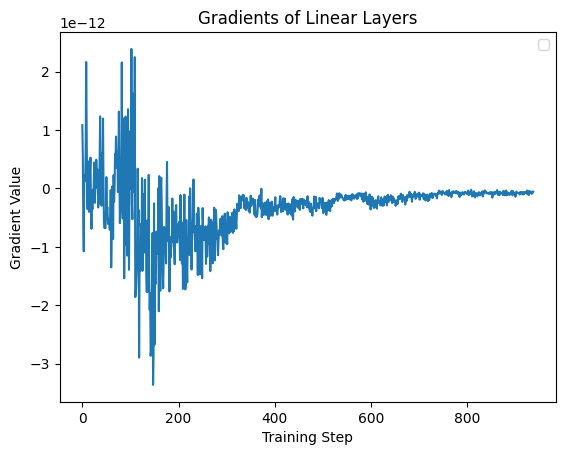

In [78]:
# Визуализируйте градиент:
plt.plot(fc_gradients)
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Как видите, после примерно 300 итерации градиент начал *затухать*, что означает, что веса скрытых слоев перестали обучаться. По этой причине лосс и перестал уменьшаться, т.к. градиент стал слишком мал чтобы влиять на веса слоев.

Глубокие модели (с большим числом скрытых слоев) подвержены проблеме затухания градиента, что приводит к тому, что такие модели не могут обучаться эффективно. 

Одна из причин этого (в этом примере) это использования sigmoid в качестве функции активации. Давайте изменим функцию активации на ReLU и переобучим модель еще раз.

**Задача 5:** Замените sigmoid на ReLU

In [79]:
# Замените sigmoid на ReLU:
class DeepMLP_ReLU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden):
        super(DeepMLP_ReLU, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))  # <---- Замена Sigmoid → ReLU
        x = self.output_layer(x)
        return x

**Вопрос:** Посчитайте и выведите сумму всех выходов модели для рандомного входного тензора test_input

**Пример ответа:** `0.234`

In [80]:
# Инициализируйте модель с ReLU:
torch.manual_seed(42)

input_size = 28 * 28
hidden_size = 32
output_size = 10
n_hidden=10
model_relu = DeepMLP_ReLU(input_size, hidden_size, output_size, n_hidden).to(device)

In [81]:
torch.manual_seed(42)
test_input = torch.rand(1, 28*28).to(device)
answer = answer = model(test_data).sum().item()
answer   # -0.25742071866989136

-0.25742071866989136

In [82]:
# Обучите модель с ReLU:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_relu.parameters(), lr=0.01)

fc_gradients = train(model_relu, trainloader, criterion, optimizer)

  2%|▏         | 17/938 [00:02<01:48,  8.52it/s]

Step: 0, Loss: 2.3037009239196777
Step: 10, Loss: 2.2954559326171875
Step: 20, Loss: 2.302825689315796
Step: 30, Loss: 2.304783821105957


  7%|▋         | 68/938 [00:03<00:18, 47.45it/s]

Step: 40, Loss: 2.2694711685180664
Step: 50, Loss: 2.2856903076171875
Step: 60, Loss: 1.9966484308242798
Step: 70, Loss: 1.9287447929382324


 11%|█         | 105/938 [00:03<00:09, 84.76it/s]

Step: 80, Loss: 1.8973199129104614
Step: 90, Loss: 1.7685163021087646
Step: 100, Loss: 1.8173105716705322
Step: 110, Loss: 1.955202341079712


 15%|█▍        | 139/938 [00:03<00:06, 114.57it/s]

Step: 120, Loss: 1.6679084300994873
Step: 130, Loss: 1.5931148529052734
Step: 140, Loss: 1.538968801498413
Step: 150, Loss: 1.409347414970398


 20%|██        | 192/938 [00:03<00:05, 148.64it/s]

Step: 160, Loss: 1.351853609085083
Step: 170, Loss: 1.4333086013793945
Step: 180, Loss: 1.3581258058547974
Step: 190, Loss: 1.3132116794586182


 24%|██▍       | 228/938 [00:03<00:04, 162.78it/s]

Step: 200, Loss: 1.2678800821304321
Step: 210, Loss: 1.6399625539779663
Step: 220, Loss: 1.5026649236679077
Step: 230, Loss: 1.3431496620178223


 28%|██▊       | 263/938 [00:04<00:04, 162.86it/s]

Step: 240, Loss: 2.2132718563079834
Step: 250, Loss: 2.0394704341888428
Step: 260, Loss: 1.7081105709075928
Step: 270, Loss: 1.69790780544281


 32%|███▏      | 298/938 [00:04<00:03, 166.57it/s]

Step: 280, Loss: 1.5532135963439941
Step: 290, Loss: 1.5197206735610962
Step: 300, Loss: 1.5520026683807373
Step: 310, Loss: 1.4450328350067139


 37%|███▋      | 347/938 [00:04<00:03, 151.62it/s]

Step: 320, Loss: 1.4276479482650757
Step: 330, Loss: 1.3816813230514526
Step: 340, Loss: 1.6483207941055298
Step: 350, Loss: 1.4175212383270264


 41%|████      | 380/938 [00:04<00:03, 156.07it/s]

Step: 360, Loss: 1.2679309844970703
Step: 370, Loss: 1.5856760740280151
Step: 380, Loss: 1.5568403005599976
Step: 390, Loss: 1.4607608318328857


 46%|████▌     | 430/938 [00:05<00:03, 154.81it/s]

Step: 400, Loss: 1.6147668361663818
Step: 410, Loss: 1.4588452577590942
Step: 420, Loss: 1.4445587396621704
Step: 430, Loss: 1.251037359237671


 49%|████▉     | 464/938 [00:05<00:02, 160.44it/s]

Step: 440, Loss: 1.2525910139083862
Step: 450, Loss: 1.2337523698806763
Step: 460, Loss: 1.317148208618164
Step: 470, Loss: 1.265053391456604


 53%|█████▎    | 499/938 [00:05<00:02, 165.48it/s]

Step: 480, Loss: 1.300365924835205
Step: 490, Loss: 1.3254722356796265
Step: 500, Loss: 1.5841652154922485
Step: 510, Loss: 1.4305542707443237


 59%|█████▉    | 553/938 [00:06<00:02, 174.04it/s]

Step: 520, Loss: 1.552596926689148
Step: 530, Loss: 1.6690757274627686
Step: 540, Loss: 1.5904381275177002
Step: 550, Loss: 1.4606177806854248


 63%|██████▎   | 589/938 [00:06<00:01, 174.60it/s]

Step: 560, Loss: 1.2820799350738525
Step: 570, Loss: 1.5195910930633545
Step: 580, Loss: 1.4972262382507324
Step: 590, Loss: 1.58010733127594


 67%|██████▋   | 625/938 [00:06<00:01, 171.18it/s]

Step: 600, Loss: 1.2470954656600952
Step: 610, Loss: 1.2683359384536743
Step: 620, Loss: 1.4094685316085815
Step: 630, Loss: 1.7385910749435425
Step: 640, Loss: 1.3429327011108398


 73%|███████▎  | 681/938 [00:06<00:01, 176.14it/s]

Step: 650, Loss: 1.520493507385254
Step: 660, Loss: 1.6742908954620361
Step: 670, Loss: 1.309253215789795
Step: 680, Loss: 1.7837144136428833


 76%|███████▋  | 717/938 [00:06<00:01, 176.33it/s]

Step: 690, Loss: 1.3911323547363281
Step: 700, Loss: 1.3656210899353027
Step: 710, Loss: 1.0848538875579834
Step: 720, Loss: 1.1982661485671997


 80%|████████  | 753/938 [00:07<00:01, 173.87it/s]

Step: 730, Loss: 1.4269403219223022
Step: 740, Loss: 1.0965789556503296
Step: 750, Loss: 1.1463234424591064
Step: 760, Loss: 1.1249804496765137


 84%|████████▍ | 789/938 [00:07<00:00, 169.36it/s]

Step: 770, Loss: 1.1693611145019531
Step: 780, Loss: 1.2096422910690308
Step: 790, Loss: 1.488593578338623
Step: 800, Loss: 1.1810373067855835


 90%|████████▉ | 843/938 [00:07<00:00, 174.45it/s]

Step: 810, Loss: 1.6621843576431274
Step: 820, Loss: 1.472716212272644
Step: 830, Loss: 1.7755213975906372
Step: 840, Loss: 1.473854660987854


 94%|█████████▎| 879/938 [00:07<00:00, 166.55it/s]

Step: 850, Loss: 1.6560821533203125
Step: 860, Loss: 1.0810636281967163
Step: 870, Loss: 1.1401145458221436
Step: 880, Loss: 0.9456584453582764


 97%|█████████▋| 914/938 [00:08<00:00, 168.59it/s]

Step: 890, Loss: 1.4355645179748535
Step: 900, Loss: 1.1599091291427612
Step: 910, Loss: 1.0387941598892212
Step: 920, Loss: 1.2877061367034912


 99%|█████████▉| 931/938 [00:08<00:00, 168.71it/s]

Step: 930, Loss: 1.3347512483596802


100%|██████████| 938/938 [00:08<00:00, 106.21it/s]


C:\Users\khari\AppData\Local\Temp\ipykernel_16900\2806989764.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


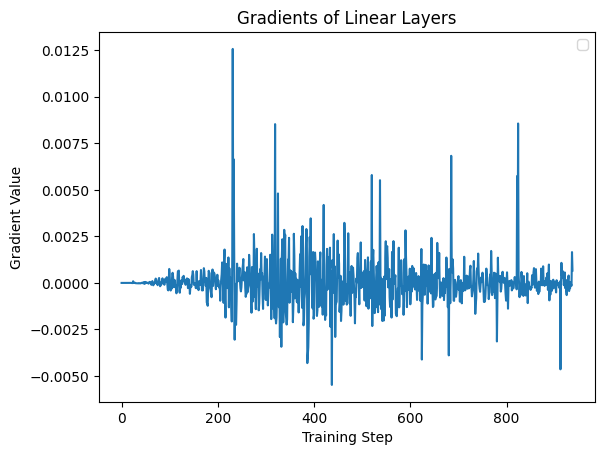

In [83]:
# Визуализируйте градинте:
plt.plot(fc_gradients)
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Вы должны получить лосс в диапазоне 1.3-1.6. Проблема затухания градиента должна уменьшится, но не решиться полностью. Обучение глубоких нейронных сетей является нетривиальной задачей!

# Проблема взрыва градиента

Это проблема противоположна предыдущей. Вместо стремления градиента к 0, и потери способности изменять веса слоев (а значит и обучаться), градиент может "взорваться" (его значения стремятся к большим числам), что приводит к очень большим и резким изменениям весов модели, не позволяя модели сходиться.

**Задача 6:** Инициализируйте модель еще раз со следующими входными параметрами.

In [84]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 512
output_size = 10
n_hidden=20
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Посчитайте и выведите сумму всех выходов модели для рандмного входного тензора test_input (да да, еще раз)

**Пример ответа:** `0.234`

In [ ]:
torch.manual_seed(42)
test_input = torch.rand(1, 28*28).to(device)
answer = model(test_data).sum().item()
answer   # -0.9367365837097168

-0.9367365837097168

In [86]:
# Обучите модель еще раз:
torch.manual_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

fc_gradients = train(model, trainloader, criterion, optimizer)

  2%|▏         | 15/938 [00:02<02:02,  7.55it/s]

Step: 0, Loss: 2.370612144470215
Step: 10, Loss: 2.319352149963379
Step: 20, Loss: 2.3845596313476562


  4%|▍         | 42/938 [00:02<00:33, 26.81it/s]

Step: 30, Loss: 2.322371482849121
Step: 40, Loss: 2.3334951400756836
Step: 50, Loss: 2.335846185684204


  9%|▉         | 83/938 [00:03<00:13, 65.59it/s]

Step: 60, Loss: 2.337700605392456
Step: 70, Loss: 2.2949411869049072
Step: 80, Loss: 2.3135998249053955


 12%|█▏        | 111/938 [00:03<00:08, 92.12it/s]

Step: 90, Loss: 2.3037660121917725
Step: 100, Loss: 2.3035049438476562
Step: 110, Loss: 2.311680316925049


 15%|█▍        | 139/938 [00:03<00:07, 105.64it/s]

Step: 120, Loss: 2.2950565814971924
Step: 130, Loss: 2.2916626930236816
Step: 140, Loss: 2.303668260574341


 18%|█▊        | 165/938 [00:03<00:06, 111.71it/s]

Step: 150, Loss: 2.308089017868042
Step: 160, Loss: 2.294508695602417
Step: 170, Loss: 2.299661636352539


 22%|██▏       | 205/938 [00:04<00:05, 122.99it/s]

Step: 180, Loss: 2.30952787399292
Step: 190, Loss: 2.3046488761901855
Step: 200, Loss: 2.2925260066986084


 23%|██▎       | 218/938 [00:04<00:05, 121.75it/s]

Step: 210, Loss: 2.297971725463867
Step: 220, Loss: 2.318708658218384
Step: 230, Loss: 2.296956777572632


 28%|██▊       | 258/938 [00:04<00:05, 127.49it/s]

Step: 240, Loss: 2.320816993713379
Step: 250, Loss: 2.3015005588531494
Step: 260, Loss: 2.3070170879364014


 30%|███       | 286/938 [00:04<00:04, 131.14it/s]

Step: 270, Loss: 2.304478168487549
Step: 280, Loss: 2.3052568435668945
Step: 290, Loss: 2.3059659004211426


 35%|███▍      | 328/938 [00:05<00:04, 134.86it/s]

Step: 300, Loss: 2.3120131492614746
Step: 310, Loss: 2.291264057159424
Step: 320, Loss: 2.298677682876587


 36%|███▋      | 342/938 [00:05<00:04, 131.77it/s]

Step: 330, Loss: 2.296095848083496
Step: 340, Loss: 2.305849313735962
Step: 350, Loss: 2.3076021671295166


 39%|███▉      | 370/938 [00:05<00:04, 128.89it/s]

Step: 360, Loss: 2.2834112644195557
Step: 370, Loss: 2.298788547515869
Step: 380, Loss: 2.303243398666382


 44%|████▍     | 413/938 [00:05<00:03, 133.17it/s]

Step: 390, Loss: 2.30169415473938
Step: 400, Loss: 2.3153207302093506
Step: 410, Loss: 2.3035590648651123


 47%|████▋     | 441/938 [00:06<00:03, 132.96it/s]

Step: 420, Loss: 2.306708812713623
Step: 430, Loss: 2.301382064819336
Step: 440, Loss: 2.3099207878112793


 50%|█████     | 470/938 [00:06<00:03, 133.43it/s]

Step: 450, Loss: 2.3080389499664307
Step: 460, Loss: 2.2981133460998535
Step: 470, Loss: 2.296691417694092


 53%|█████▎    | 497/938 [00:06<00:03, 129.41it/s]

Step: 480, Loss: 2.2905995845794678
Step: 490, Loss: 2.301241636276245
Step: 500, Loss: 2.303941249847412


 56%|█████▌    | 525/938 [00:06<00:03, 128.83it/s]

Step: 510, Loss: 2.3054370880126953
Step: 520, Loss: 2.295975923538208
Step: 530, Loss: 2.297809362411499


 61%|██████    | 568/938 [00:06<00:02, 133.12it/s]

Step: 540, Loss: 2.3027031421661377
Step: 550, Loss: 2.3001868724823
Step: 560, Loss: 2.296241283416748


 64%|██████▎   | 596/938 [00:07<00:02, 133.72it/s]

Step: 570, Loss: 2.3105452060699463
Step: 580, Loss: 2.3034369945526123
Step: 590, Loss: 2.313382625579834


 67%|██████▋   | 624/938 [00:07<00:02, 134.69it/s]

Step: 600, Loss: 2.293776273727417
Step: 610, Loss: 2.31894588470459
Step: 620, Loss: 2.300178289413452


 70%|██████▉   | 652/938 [00:07<00:02, 131.27it/s]

Step: 630, Loss: 2.309185266494751
Step: 640, Loss: 2.2854819297790527
Step: 650, Loss: 2.299595355987549


 72%|███████▏  | 680/938 [00:07<00:01, 130.09it/s]

Step: 660, Loss: 2.3087778091430664
Step: 670, Loss: 2.292625665664673
Step: 680, Loss: 2.312490224838257
Step: 690, Loss: 2.3027212619781494


 77%|███████▋  | 722/938 [00:08<00:01, 130.07it/s]

Step: 700, Loss: 2.3031020164489746
Step: 710, Loss: 2.2977707386016846
Step: 720, Loss: 2.310284376144409


 80%|███████▉  | 749/938 [00:08<00:01, 125.72it/s]

Step: 730, Loss: 2.3078012466430664
Step: 740, Loss: 2.2944319248199463
Step: 750, Loss: 2.296509027481079


 83%|████████▎ | 775/938 [00:08<00:01, 125.84it/s]

Step: 760, Loss: 2.3016974925994873
Step: 770, Loss: 2.315286636352539
Step: 780, Loss: 2.292431116104126


 87%|████████▋ | 816/938 [00:08<00:00, 131.38it/s]

Step: 790, Loss: 2.2961673736572266
Step: 800, Loss: 2.2978837490081787
Step: 810, Loss: 2.3135786056518555


 90%|████████▉ | 844/938 [00:09<00:00, 130.00it/s]

Step: 820, Loss: 2.307420015335083
Step: 830, Loss: 2.3165268898010254
Step: 840, Loss: 2.305375337600708


 93%|█████████▎| 872/938 [00:09<00:00, 132.68it/s]

Step: 850, Loss: 2.3068716526031494
Step: 860, Loss: 2.3002524375915527
Step: 870, Loss: 2.2848074436187744
Step: 880, Loss: 2.3027477264404297


 98%|█████████▊| 915/938 [00:09<00:00, 132.49it/s]

Step: 890, Loss: 2.299281358718872
Step: 900, Loss: 2.3038330078125
Step: 910, Loss: 2.2965760231018066


 99%|█████████▉| 929/938 [00:09<00:00, 130.66it/s]

Step: 920, Loss: 2.298959970474243
Step: 930, Loss: 2.294469118118286


100%|██████████| 938/938 [00:10<00:00, 90.39it/s] 


C:\Users\khari\AppData\Local\Temp\ipykernel_16900\2019969697.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


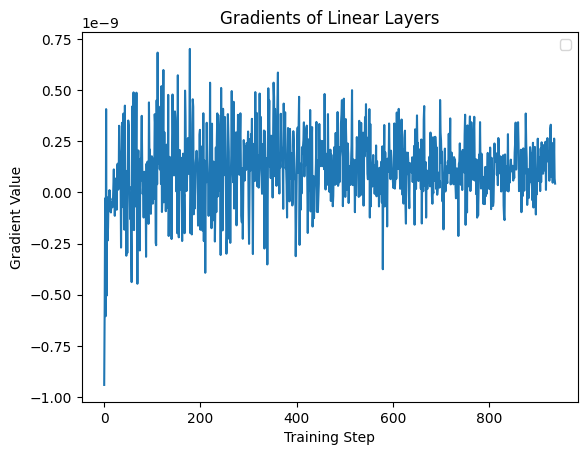

In [130]:
# Визуализируйте градиент:
plt.plot(fc_gradients)
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Как видите, магнитуда градиента стала слишком большой, что приводит к тому, что модель не может сойтись (достичь минимума).

# ResNet

Теперь давайте попробуем реализовать модель ResNet. Ее авторы нашли способ как бороться с проблемой затухания градиента в глубоких сетях используя так называемые shortcut (или residual) связи между слоями.

**Задача 7:** Определите Residual Block

In [131]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

**Вопрос:** Посчитайте и выведите сумму выходов ResidualBlock(10,10) для рандомного входного тензора test_input.

**Пример ответа:** `1.234`

In [ ]:
torch.manual_seed(42)
test_input = torch.rand((1, 10, 3, 28*28))
res_block = ResidualBlock(10,10)
answer = res_block(test_input).sum().item()
answer   # 16789.064453125

16789.064453125

**Задача 8:** Теперь определите модель ResNet, состоящую из нескольких ResidualBlock

In [133]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=1)
        self.layer3 = self._make_layer(128, 256, 2, stride=1)
        self.fc = nn.Linear(2304, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(ResidualBlock(in_channels, out_channels, stride))
            else:
                layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

**Вопрос:** Посчитайте и выведите количество параметров (весов) этой ResNet модели

**Пример ответа:** `43242`

In [134]:
model = ResNet()

answer = sum(param.numel() for param in model.parameters())
answer   # 2799114

2799114

In [135]:
# Инициализируем объект класса модели ResNet, а также лосс функцию и оптимайзер:
torch.manual_seed(42)

model = ResNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [136]:
# Теперь обучите эту модель:
torch.manual_seed(42)

model.train()

fc_gradients = []

for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    loss.backward()
    optimizer.step()

    if step % 10 == 0:
      print(f'Step: {step}, Loss: {loss}')

    fc_gradients.append(model.fc.weight.grad.mean().item())

  1%|          | 5/938 [00:02<06:54,  2.25it/s]

Step: 0, Loss: 2.4626057147979736


  1%|▏         | 14/938 [00:03<01:47,  8.62it/s]

Step: 10, Loss: 3.7753219604492188


  3%|▎         | 26/938 [00:03<00:48, 18.82it/s]

Step: 20, Loss: 1.874342679977417


  4%|▎         | 35/938 [00:04<00:38, 23.61it/s]

Step: 30, Loss: 1.0179262161254883


  5%|▍         | 45/938 [00:04<00:32, 27.12it/s]

Step: 40, Loss: 0.4775063395500183


  6%|▌         | 54/938 [00:04<00:32, 27.07it/s]

Step: 50, Loss: 0.5569607615470886


  7%|▋         | 63/938 [00:05<00:32, 26.58it/s]

Step: 60, Loss: 0.18007951974868774


  8%|▊         | 75/938 [00:05<00:30, 28.08it/s]

Step: 70, Loss: 0.18278135359287262


  9%|▉         | 84/938 [00:05<00:31, 27.43it/s]

Step: 80, Loss: 0.32549914717674255


 10%|█         | 96/938 [00:06<00:31, 26.55it/s]

Step: 90, Loss: 0.27424973249435425


 11%|█         | 105/938 [00:06<00:30, 27.19it/s]

Step: 100, Loss: 0.32721787691116333


 12%|█▏        | 114/938 [00:06<00:30, 27.38it/s]

Step: 110, Loss: 0.3308010697364807


 13%|█▎        | 126/938 [00:07<00:30, 27.00it/s]

Step: 120, Loss: 0.332346647977829


 14%|█▍        | 135/938 [00:07<00:29, 26.87it/s]

Step: 130, Loss: 0.12835809588432312


 15%|█▌        | 144/938 [00:08<00:29, 27.00it/s]

Step: 140, Loss: 0.32903769612312317


 17%|█▋        | 156/938 [00:08<00:28, 27.18it/s]

Step: 150, Loss: 0.07242213934659958


 18%|█▊        | 165/938 [00:08<00:28, 26.69it/s]

Step: 160, Loss: 0.1311742216348648


 19%|█▊        | 174/938 [00:09<00:27, 27.57it/s]

Step: 170, Loss: 0.2593122720718384


 20%|█▉        | 186/938 [00:09<00:27, 27.14it/s]

Step: 180, Loss: 0.08691791445016861


 21%|██        | 195/938 [00:09<00:27, 26.88it/s]

Step: 190, Loss: 0.31926867365837097


 22%|██▏       | 204/938 [00:10<00:26, 27.60it/s]

Step: 200, Loss: 0.2576506733894348


 23%|██▎       | 213/938 [00:10<00:26, 27.44it/s]

Step: 210, Loss: 0.378024160861969


 24%|██▍       | 225/938 [00:10<00:26, 27.25it/s]

Step: 220, Loss: 0.1078704223036766


 25%|██▍       | 234/938 [00:11<00:25, 27.12it/s]

Step: 230, Loss: 0.16941408812999725


 26%|██▌       | 246/938 [00:11<00:25, 27.67it/s]

Step: 240, Loss: 0.06753311306238174


 27%|██▋       | 255/938 [00:12<00:24, 27.39it/s]

Step: 250, Loss: 0.11595398932695389


 28%|██▊       | 265/938 [00:12<00:24, 27.89it/s]

Step: 260, Loss: 0.1358184665441513


 29%|██▉       | 274/938 [00:12<00:24, 26.87it/s]

Step: 270, Loss: 0.07513502985239029


 30%|███       | 284/938 [00:13<00:23, 27.49it/s]

Step: 280, Loss: 0.04025663807988167


 31%|███       | 293/938 [00:13<00:23, 27.74it/s]

Step: 290, Loss: 0.11715888977050781


 33%|███▎      | 305/938 [00:13<00:22, 27.59it/s]

Step: 300, Loss: 0.3512425720691681


 33%|███▎      | 314/938 [00:14<00:22, 27.23it/s]

Step: 310, Loss: 0.06779652833938599


 35%|███▍      | 326/938 [00:14<00:21, 27.97it/s]

Step: 320, Loss: 0.14070311188697815


 36%|███▌      | 335/938 [00:14<00:21, 27.57it/s]

Step: 330, Loss: 0.144318625330925


 37%|███▋      | 344/938 [00:15<00:21, 27.39it/s]

Step: 340, Loss: 0.13330282270908356


 38%|███▊      | 353/938 [00:15<00:22, 26.41it/s]

Step: 350, Loss: 0.08477269858121872


 39%|███▉      | 365/938 [00:16<00:21, 27.01it/s]

Step: 360, Loss: 0.12059146165847778


 40%|███▉      | 374/938 [00:16<00:20, 27.47it/s]

Step: 370, Loss: 0.04606958478689194


 41%|████      | 384/938 [00:16<00:19, 28.49it/s]

Step: 380, Loss: 0.06479470431804657


 42%|████▏     | 396/938 [00:17<00:19, 27.26it/s]

Step: 390, Loss: 0.2960454523563385


 43%|████▎     | 405/938 [00:17<00:19, 27.66it/s]

Step: 400, Loss: 0.07213207334280014


 44%|████▍     | 414/938 [00:17<00:19, 26.62it/s]

Step: 410, Loss: 0.0434994138777256


 45%|████▌     | 423/938 [00:18<00:18, 27.65it/s]

Step: 420, Loss: 0.09830126911401749


 46%|████▋     | 435/938 [00:18<00:18, 27.66it/s]

Step: 430, Loss: 0.03665485978126526


 47%|████▋     | 444/938 [00:18<00:18, 27.22it/s]

Step: 440, Loss: 0.10374338924884796


 48%|████▊     | 454/938 [00:19<00:17, 27.81it/s]

Step: 450, Loss: 0.13092070817947388


 50%|████▉     | 466/938 [00:19<00:17, 27.29it/s]

Step: 460, Loss: 0.16148069500923157


 51%|█████     | 475/938 [00:20<00:17, 26.91it/s]

Step: 470, Loss: 0.05487765744328499


 52%|█████▏    | 484/938 [00:20<00:16, 27.02it/s]

Step: 480, Loss: 0.04190724343061447


 53%|█████▎    | 493/938 [00:20<00:16, 26.75it/s]

Step: 490, Loss: 0.18589171767234802


 54%|█████▍    | 505/938 [00:21<00:16, 26.50it/s]

Step: 500, Loss: 0.15013372898101807


 55%|█████▍    | 514/938 [00:21<00:15, 26.83it/s]

Step: 510, Loss: 0.06470584124326706


 56%|█████▌    | 526/938 [00:21<00:15, 27.38it/s]

Step: 520, Loss: 0.20549902319908142


 57%|█████▋    | 535/938 [00:22<00:14, 26.97it/s]

Step: 530, Loss: 0.166385218501091


 58%|█████▊    | 546/938 [00:22<00:13, 28.73it/s]

Step: 540, Loss: 0.12095716595649719


 59%|█████▉    | 555/938 [00:23<00:14, 26.83it/s]

Step: 550, Loss: 0.08769167959690094


 60%|██████    | 564/938 [00:23<00:13, 27.61it/s]

Step: 560, Loss: 0.05304275453090668


 61%|██████    | 573/938 [00:23<00:13, 27.42it/s]

Step: 570, Loss: 0.15489773452281952


 62%|██████▏   | 583/938 [00:24<00:12, 27.68it/s]

Step: 580, Loss: 0.2613794803619385


 63%|██████▎   | 595/938 [00:24<00:12, 28.03it/s]

Step: 590, Loss: 0.284354567527771


 64%|██████▍   | 604/938 [00:24<00:11, 27.86it/s]

Step: 600, Loss: 0.19721372425556183


 65%|██████▌   | 613/938 [00:25<00:11, 27.12it/s]

Step: 610, Loss: 0.13961316645145416


 67%|██████▋   | 625/938 [00:25<00:11, 27.77it/s]

Step: 620, Loss: 0.06740856170654297


 68%|██████▊   | 634/938 [00:25<00:11, 27.56it/s]

Step: 630, Loss: 0.15936431288719177


 69%|██████▉   | 646/938 [00:26<00:10, 27.88it/s]

Step: 640, Loss: 0.09491710364818573


 70%|██████▉   | 656/938 [00:26<00:10, 27.46it/s]

Step: 650, Loss: 0.08580014109611511


 71%|███████   | 665/938 [00:27<00:09, 27.64it/s]

Step: 660, Loss: 0.15485024452209473


 72%|███████▏  | 674/938 [00:27<00:09, 27.16it/s]

Step: 670, Loss: 0.08207955211400986


 73%|███████▎  | 686/938 [00:27<00:09, 27.95it/s]

Step: 680, Loss: 0.17460229992866516


 74%|███████▍  | 695/938 [00:28<00:08, 27.71it/s]

Step: 690, Loss: 0.24633172154426575


 75%|███████▌  | 704/938 [00:28<00:08, 26.84it/s]

Step: 700, Loss: 0.043094735592603683


 76%|███████▌  | 713/938 [00:28<00:08, 27.08it/s]

Step: 710, Loss: 0.15781435370445251


 77%|███████▋  | 725/938 [00:29<00:07, 27.24it/s]

Step: 720, Loss: 0.042251765727996826


 78%|███████▊  | 734/938 [00:29<00:07, 27.11it/s]

Step: 730, Loss: 0.09390521049499512


 80%|███████▉  | 746/938 [00:30<00:07, 27.22it/s]

Step: 740, Loss: 0.06087684631347656


 80%|████████  | 755/938 [00:30<00:06, 26.82it/s]

Step: 750, Loss: 0.010757016018033028


 81%|████████▏ | 764/938 [00:30<00:06, 27.67it/s]

Step: 760, Loss: 0.041678350418806076


 83%|████████▎ | 777/938 [00:31<00:05, 28.22it/s]

Step: 770, Loss: 0.12521478533744812


 84%|████████▍ | 786/938 [00:31<00:05, 27.98it/s]

Step: 780, Loss: 0.16712269186973572


 85%|████████▍ | 795/938 [00:31<00:05, 26.81it/s]

Step: 790, Loss: 0.21051017940044403


 86%|████████▌ | 804/938 [00:32<00:04, 26.98it/s]

Step: 800, Loss: 0.09699850529432297


 87%|████████▋ | 813/938 [00:32<00:04, 26.99it/s]

Step: 810, Loss: 0.02750982902944088


 88%|████████▊ | 825/938 [00:32<00:04, 27.14it/s]

Step: 820, Loss: 0.20078490674495697


 89%|████████▉ | 834/938 [00:33<00:03, 27.18it/s]

Step: 830, Loss: 0.07723701745271683


 90%|████████▉ | 843/938 [00:33<00:03, 27.54it/s]

Step: 840, Loss: 0.1413576453924179


 91%|█████████ | 855/938 [00:34<00:03, 27.40it/s]

Step: 850, Loss: 0.146440327167511


 92%|█████████▏| 864/938 [00:34<00:02, 26.86it/s]

Step: 860, Loss: 0.09153573215007782


 93%|█████████▎| 873/938 [00:34<00:02, 27.38it/s]

Step: 870, Loss: 0.16315925121307373


 94%|█████████▍| 885/938 [00:35<00:01, 27.64it/s]

Step: 880, Loss: 0.08974064141511917


 95%|█████████▌| 894/938 [00:35<00:01, 27.46it/s]

Step: 890, Loss: 0.017600491642951965


 96%|█████████▋| 903/938 [00:35<00:01, 26.82it/s]

Step: 900, Loss: 0.11991444230079651


 98%|█████████▊| 915/938 [00:36<00:00, 27.87it/s]

Step: 910, Loss: 0.059584926813840866


 99%|█████████▊| 924/938 [00:36<00:00, 27.47it/s]

Step: 920, Loss: 0.04644796997308731


100%|█████████▉| 934/938 [00:36<00:00, 27.27it/s]

Step: 930, Loss: 0.11982883512973785


100%|██████████| 938/938 [00:37<00:00, 24.97it/s]


Как можете видеть, лосс продолжает уменьшаться. Теперь попробуйте визиулизировать градиент накопленный в переменной fc_gradients

C:\Users\khari\AppData\Local\Temp\ipykernel_16900\2019969697.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


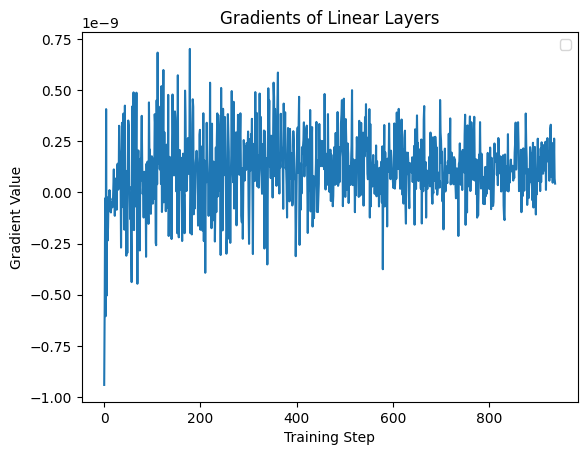

In [137]:
# Визуализируйте градиент:
plt.plot(fc_gradients)
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Теперь градиент кажется достаточно стабильным, и это позволяет ResNet модели обучаться лучше предыдущей модели, которая была подвержена проблеме затухания градента. Таким способом ResNet стала SOTA моделью в 2015 году и выиграла ImageNet competition.

Наконец, давайте сохраним параметры (веса) обученной модели чтобы переиспользовать их позже:

In [138]:
checkpoint_path = './mnist_checkpoint.pth'
torch.save(model.state_dict(), checkpoint_path)

# Transfer Learning

Перед тем как мы перейдем к технике обучения называемой Transfer Learning, давайте сперва протестируем нашу модель на тестовой подвыборке датасета MNIST. Чтобы сделать это, вам необходимо скачать тестовую подвыборку схожим образом, как вы уже скачали подвыборку для обучения с тем отличием, что нужно изменить параметр `train=False`:

In [139]:
# Загрузите тестовую подвыборку датасета MNIST:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Теперь нам нужно имплементировать функцию для тестирования модели, в которой мы будем считать точность (accuracy) нашей модели (т.е. процент правильных предсказаний):

In [140]:
def test(model, dataloader):
  model.eval()

  with torch.no_grad():
    correct = 0

    for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
        
    accuracy = correct/len(dataloader.dataset)

    return accuracy

Теперь загрузите ранее сохраненные параметры (веса) обученной ResNet модели:

**Задача 9:** Посчитайте точность модели на тесте.

In [141]:
model = ResNet()
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

**Вопрос:** Посчитайте и выведите точность модели на тестовой выборке MNIST.

**Пример ответа:** `22.45`

In [142]:
accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")  

100%|██████████| 157/157 [00:05<00:00, 31.36it/s]


MNIST test accuracy: 97.50999999999999%


Вы должны получить точность примерно 96% или выше.

Теперь давайте попробуем загрузить другой датасет - CIFAR10, который состоит из 10 классов, но содержит изображения не рукописаных цифр, а объектов (horses, dogs, cars, и др.). Изображения имеют размер 32x32 и три цветовых канала (RGB). Поэтому нам также нужно изменить трансформации (transforms), чтобы изображения CIFAR10 соответствовали  изображениям MNIST (т.е. 28x28 в формате grayscale):

In [143]:
# Трансформации для датасета CIFAR10:
transform_cifar10 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28,28)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Выборка для обучения:
trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=True, download=True, transform=transform_cifar10)
trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=64, shuffle=True, num_workers=2)

# Выборка для тестирования:
testset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=False, download=True, transform=transform_cifar10)
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=64, shuffle=False, num_workers=2)

Теперь протестируйте ранее обученную ResNet модель на тестовой выборке датасета CIFAR10 (пока переобучать модель не нужно!):

**Задача 10:** Протестируйте модель на тестовой выборке CIFAR10

**Вопрос:** Посчитайте и выведите точность модели на тесте

**Пример ответа:** `22.45`

In [144]:
accuracy = test(model, testloader_cifar10)
print(f"\nTest accuracy: {100*accuracy}%")  

100%|██████████| 157/157 [00:02<00:00, 64.27it/s]


Test accuracy: 10.03%


Как видите, точность на CIFAR10 не очень большая (около 10%). И это не удивительно, ведь мы обучали нашу ResNet модель на другом датасете (MNIST).

Теперь давайте заморозим все слои за исключением последнего (т.е. слоя классификации):

**Задача 11:** Заморозьте слои модели кроме последнего

In [145]:
for param in model.parameters():
    param.requires_grad = False              # отключаем градиент (т.е. "замораживаем" слои)
    
mnist_fc = model.fc                          # Сохраняем в переменную слой классификации MNIST
in_features = model.fc.in_features         
model.fc = torch.nn.Linear(in_features, 10)  # Создаем новый слой классификации для CIFAR10
model.fc = model.fc.cuda()

**Вопрос:** Посчитайте и выведите количество параметров (весов) в замороженных слоях

**Пример ответа:** `224513`

In [146]:
frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
frozen_params   # 2776064

2776064

**Задача 12:** Обучите только последний слой модели на датасете CIFAR10 (все остальные слои должны быть заморожены)

In [147]:
torch.manual_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for step, data in tqdm(enumerate(trainloader_cifar10), total=len(trainloader_cifar10)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    if step % 10 == 0:
      print(f'Step: {step}, Loss: {loss}')

  2%|▏         | 15/782 [00:00<00:10, 74.40it/s]

Step: 0, Loss: 2.3097453117370605
Step: 10, Loss: 2.8638358116149902


  4%|▍         | 33/782 [00:00<00:09, 79.56it/s]

Step: 20, Loss: 2.222452402114868
Step: 30, Loss: 2.3062803745269775


  7%|▋         | 51/782 [00:00<00:08, 82.57it/s]

Step: 40, Loss: 2.1798365116119385
Step: 50, Loss: 2.064896821975708


 10%|▉         | 78/782 [00:00<00:08, 83.19it/s]

Step: 60, Loss: 2.198005199432373
Step: 70, Loss: 1.6822034120559692


 12%|█▏        | 96/782 [00:01<00:08, 82.98it/s]

Step: 80, Loss: 2.2860848903656006
Step: 90, Loss: 2.4544875621795654


 15%|█▍        | 114/782 [00:01<00:08, 82.80it/s]

Step: 100, Loss: 2.0239248275756836
Step: 110, Loss: 2.14754319190979


 17%|█▋        | 132/782 [00:01<00:07, 85.22it/s]

Step: 120, Loss: 1.9227399826049805
Step: 130, Loss: 2.4311699867248535


 19%|█▉        | 150/782 [00:01<00:07, 82.95it/s]

Step: 140, Loss: 2.352541923522949
Step: 150, Loss: 1.898016333580017


 23%|██▎       | 177/782 [00:02<00:07, 85.20it/s]

Step: 160, Loss: 2.5645298957824707
Step: 170, Loss: 2.018249034881592


 25%|██▍       | 195/782 [00:02<00:06, 84.05it/s]

Step: 180, Loss: 2.2287814617156982
Step: 190, Loss: 2.35846209526062


 27%|██▋       | 213/782 [00:02<00:06, 85.68it/s]

Step: 200, Loss: 2.17071533203125
Step: 210, Loss: 2.03664231300354


 30%|██▉       | 231/782 [00:02<00:06, 83.20it/s]

Step: 220, Loss: 1.963163137435913
Step: 230, Loss: 1.9238333702087402


 33%|███▎      | 258/782 [00:03<00:06, 86.60it/s]

Step: 240, Loss: 1.9738577604293823
Step: 250, Loss: 1.987750768661499


 35%|███▌      | 276/782 [00:03<00:05, 85.36it/s]

Step: 260, Loss: 2.1648662090301514
Step: 270, Loss: 2.398730993270874


 38%|███▊      | 294/782 [00:03<00:05, 84.67it/s]

Step: 280, Loss: 2.3091177940368652
Step: 290, Loss: 1.989311695098877


 40%|███▉      | 312/782 [00:03<00:05, 84.20it/s]

Step: 300, Loss: 1.9529881477355957
Step: 310, Loss: 2.0085086822509766


 42%|████▏     | 330/782 [00:03<00:05, 85.35it/s]

Step: 320, Loss: 2.4554555416107178
Step: 330, Loss: 2.208711862564087


 46%|████▌     | 357/782 [00:04<00:04, 85.98it/s]

Step: 340, Loss: 1.8699324131011963
Step: 350, Loss: 1.9425673484802246


 48%|████▊     | 375/782 [00:04<00:04, 85.21it/s]

Step: 360, Loss: 1.8762149810791016
Step: 370, Loss: 1.801551103591919


 50%|█████     | 393/782 [00:04<00:04, 86.03it/s]

Step: 380, Loss: 1.6467335224151611
Step: 390, Loss: 2.1146810054779053


 53%|█████▎    | 411/782 [00:04<00:04, 86.03it/s]

Step: 400, Loss: 2.0365355014801025
Step: 410, Loss: 2.280163526535034


 55%|█████▍    | 429/782 [00:05<00:04, 86.92it/s]

Step: 420, Loss: 2.3956754207611084
Step: 430, Loss: 2.3004753589630127


 58%|█████▊    | 457/782 [00:05<00:03, 89.26it/s]

Step: 440, Loss: 2.1930742263793945
Step: 450, Loss: 2.0699400901794434


 61%|██████    | 475/782 [00:05<00:03, 86.66it/s]

Step: 460, Loss: 2.1654062271118164
Step: 470, Loss: 2.2862794399261475


 63%|██████▎   | 493/782 [00:05<00:03, 85.13it/s]

Step: 480, Loss: 2.416487216949463
Step: 490, Loss: 2.0052008628845215


 65%|██████▌   | 511/782 [00:06<00:03, 83.28it/s]

Step: 500, Loss: 2.2113637924194336
Step: 510, Loss: 2.343412160873413


 68%|██████▊   | 530/782 [00:06<00:02, 86.01it/s]

Step: 520, Loss: 2.2687721252441406
Step: 530, Loss: 2.4878458976745605


 71%|███████   | 557/782 [00:06<00:02, 85.88it/s]

Step: 540, Loss: 2.5113396644592285
Step: 550, Loss: 2.542372703552246


 74%|███████▎  | 575/782 [00:06<00:02, 86.75it/s]

Step: 560, Loss: 2.38966965675354
Step: 570, Loss: 2.1444475650787354


 76%|███████▌  | 593/782 [00:06<00:02, 86.83it/s]

Step: 580, Loss: 1.9879223108291626
Step: 590, Loss: 2.2555088996887207


 78%|███████▊  | 611/782 [00:07<00:02, 83.94it/s]

Step: 600, Loss: 1.9826633930206299
Step: 610, Loss: 2.007871150970459


 82%|████████▏ | 638/782 [00:07<00:01, 86.11it/s]

Step: 620, Loss: 2.1724939346313477
Step: 630, Loss: 2.2694005966186523


 84%|████████▍ | 656/782 [00:07<00:01, 84.95it/s]

Step: 640, Loss: 2.0983619689941406
Step: 650, Loss: 2.0837390422821045


 86%|████████▌ | 674/782 [00:07<00:01, 84.58it/s]

Step: 660, Loss: 1.9763212203979492
Step: 670, Loss: 2.4311671257019043


 88%|████████▊ | 692/782 [00:08<00:01, 84.33it/s]

Step: 680, Loss: 2.100964307785034
Step: 690, Loss: 2.1852431297302246


 91%|█████████ | 711/782 [00:08<00:00, 83.74it/s]

Step: 700, Loss: 2.2367055416107178
Step: 710, Loss: 2.192018508911133


 93%|█████████▎| 729/782 [00:08<00:00, 85.72it/s]

Step: 720, Loss: 2.1743006706237793
Step: 730, Loss: 2.0632824897766113


 97%|█████████▋| 756/782 [00:08<00:00, 86.47it/s]

Step: 740, Loss: 1.7804895639419556
Step: 750, Loss: 1.9529845714569092


 99%|█████████▉| 774/782 [00:09<00:00, 86.60it/s]

Step: 760, Loss: 2.0219810009002686
Step: 770, Loss: 1.8933175802230835
Step: 780, Loss: 1.942776083946228


100%|██████████| 782/782 [00:09<00:00, 79.71it/s]


**Вопрос:** Посчитайте точность на тестовой выборке CIFAR10

**Пример ответа:** `32.45`

In [148]:
accuracy = test(model, testloader_cifar10)
print(f"\nTest accuracy: {100*accuracy}%")   

100%|██████████| 157/157 [00:02<00:00, 64.02it/s]


Test accuracy: 32.629999999999995%


Как можете видеть, точность модели выросла до примерно 35%. Мы обучили только последний слой (классификации), а остальная часть сети осталось нетронутой (т.е. остальные слои обучены на датасете MNIST). Эта техника обучения и называется Transfer Learning.

Теперь протестируйте эту модель еще раз на тестовой выборке MNIST:

In [149]:
accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")  

100%|██████████| 157/157 [00:05<00:00, 29.51it/s]


MNIST test accuracy: 5.489999999999999%


Как вы можете видеть, точность упала ниже 10%, поскольку последний слой классификации теперь обучен на CIFAR10 датасете. Это называется "катастрофическим забыванием" (catastrophic forgetting). Катастрофическое забывание это тенденация нейронной сети забывать предыдущие обученные знания когда она обучается новой информации.

Наконец, давайте вернем назад ранее сохраненный слой классификации обученный на MNIST и протестируем еще раз:

**Задача 13:** Верните последний слой mnist_fc и проведите финальный тест на тестовых выборках MNIST и CIFAR10

**Вопрос:** Посчитайте и выведите точность на тестовых выборках MNIST и CIFAR10

**Пример ответа:** 
`CIFAR test accuracy: 9.45`
`MNIST test accuracy: 51.68`

In [ ]:
cifar_fc = model.fc

In [151]:

model.fc = mnist_fc # верните в модель слой классификации обученный на MNIST
model.fc = model.fc.cuda()                # Перенесем на cuda

accuracy = test(model, testloader_cifar10)
print(f"\nCIFAR test accuracy: {100*accuracy}%")

accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")  

100%|██████████| 157/157 [00:02<00:00, 63.44it/s]



CIFAR test accuracy: 8.5%


100%|██████████| 157/157 [00:05<00:00, 30.85it/s]


MNIST test accuracy: 73.42%
